# Аппроксимация коэффициентов диффузии многокомпонентной смеси с помощью нейронных сетей

## Генерация сетки в пространстве параметров
Генерируем сетку в пространстве параметров: $p$, $T$ и количественных долей компонент, и записываем её в файл input.txt

In [1]:
#TODO: Добавить текстовые метки для разных компонент, чтобы было понятно, какая 
# это молекула и на каком уровне

# Число уровней
comp_names = ['O2', 'N2', 'NO', 'O', 'N']
n_of_levels = {'O2' : 36, 'N2' : , 'NO' : }
print(n_of_levels['O2'])

SyntaxError: invalid syntax (<ipython-input-1-f65f7950c855>, line 6)

In [4]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot  as plt
from mpl_toolkits import mplot3d

# Число компонент
ncomp = 5 # Воздух, O2, N2, NO, O, N

# Число узлов по давлению
p_points = 20
# Число узлов по температуре
T_points = 20
# Число узлов по одной концентрации в сетке на симплексе
x_points = 9

# Создаём равномерные сетки по p, T
p_mesh = np.linspace(1e+5, 2.0e+5, p_points)
T_mesh = np.linspace(3.0e+2, 5e+3, T_points)

# Создаём равномерную сетку на симплексе sum(x_i) = 1
ind = 0 # Номер точки в сетке по концентрациям
h = 1 / (x_points - 1)
x_mesh = []
for i1 in range(x_points):
    x1 = i1 * h
    for i2 in range(x_points - i1):
        x2 = i2 * h
        for i3 in range(x_points - i1 - i2):
            x3 = i3 * h
            for i4 in range(x_points - i1 - i2 - i3):
                x4 = i4 * h
                x5 = 1 - x1 - x2 - x3 - x4 
                points = np.array([x1, x2, x3, x4, x5])
                assert (sum(points) - 1) < 1e-13
                if (not np.any(points < 1e-10)):
                    x_mesh.append([x1, x2, x3, x4, x5])
#                     print(x_mesh[-1])
                    ind = ind + 1
print('x_mesh size = {0:d}'.format(len(x_mesh)))

import itertools
mesh = []
for element in itertools.product(p_mesh, T_mesh, x_mesh):
#     print (type(element[0]))
#     print (type(element[1]))
#     print (type(element[2]))
    list_ = [element[0]] + [element[1]] + element[2]
    mesh.append(np.array(list_))

print(mesh[0])
mesh = np.array(mesh)
print(mesh.shape)

# write mesh to file
path = './'
file = 'input.txt'
np.savetxt(path + file, header = str(mesh.shape[0]) +'\n' + 
           'p T x1 x2 x3 x4 x5', X = mesh, comments='')

x_mesh size = 35
[1.00e+05 3.00e+02 1.25e-01 1.25e-01 1.25e-01 1.25e-01 5.00e-01]
(14000, 7)


## Вычисление матриц коэффициентов диффузии с помощью библиотеки Kappa
Вызываем программу, которая с помощью Каппа считает коэффициенты диффузии для каждой точки из файла ```input.txt``` и пишет в файл ```output.txt```

In [5]:
import time
start = time.time()
!Проект1.exe
end = time.time()
print('Time for computing coefficents: {0:5.2e}'.format(end - start))
print('Average time for one point: {0:5.2e}'.format((end - start) /mesh.shape[0]))

Diffusion coefficient written to file output.txt
Time for computing coefficents: 1.57e+03
Average time for one point: 1.12e-01


Читаем коэффициенты диффузии из файла

In [6]:
output_file = 'output.txt'

diff_coeffs = np.loadtxt(output_file)
print(diff_coeffs.shape)

(14000, 15376)


## Разные сечения многомерной зависимости

Нужно построить различные сечения зависимости для разных элементов матрицы, чтобы понять характер зависимости
1. Для фиксированных концентраций построить colormap или поверхности для зависимости от $(p,T)$
2. То же, но одномерные графики зависимостей от $p$ и $T$
3. Для фиксированных $p, T$ построить одномерные зависимости от концентраций. Например, задать 3 концентрации, для остальных двух получиться $x_1 + x_2 = 1 - (x_3 + x_4 + x_5)$, и построить зависимость от $x_1$
4. Построить зависимость коэффициентов на диагонали от номера возбужденного состояния (для молекул)

### Двумерные сечения при фиксированных концентраций

In [7]:
# Фиксируем точку по концентрациям (количественным долям)
inds = np.all(mesh[:, 2:] == x_mesh[3], axis = 1)
print('Fractions = ', x_mesh[3])

# Берём подмножество сетки
mesh_slice = mesh[inds, :]
# Подмножество данных 
data_slice = diff_coeffs[inds, :]

# Размер матрицы
N = int(np.sqrt(diff_coeffs.shape[1]))
print('Size of matrix: {0:d}'.format(N))

Fractions =  [0.125, 0.125, 0.125, 0.5, 0.125]
Size of matrix: 124


Строим двумерные зависимости от $(p,T)$

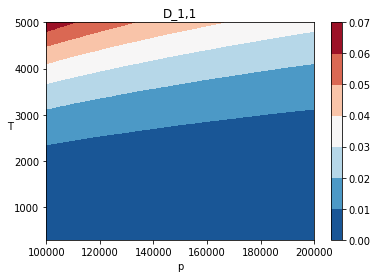

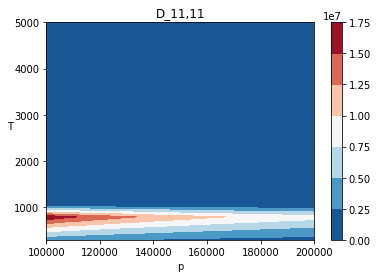

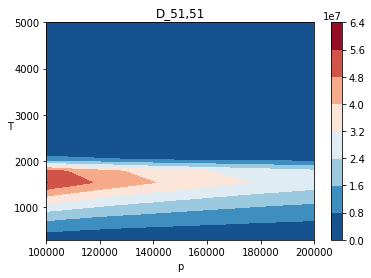

In [8]:
import matplotlib.tri as tri

p = mesh_slice[:, 0] # p
T = mesh_slice[:, 1] # T

# Индексы одного элемента матрицы


index_list = [[0, 0], 
              [10, 10], 
              [50, 50]]
for i, j in index_list:
    # Одномерный индекс для матрицы, "выпрямленной" по стобцам
    index = j * N + i

    d_ij = data_slice[:, index] # d

    triang = tri.Triangulation(p, T)
    interpolator = tri.LinearTriInterpolator(triang, d_ij)
    plt.tricontourf(p, T, d_ij, cmap="RdBu_r")
    plt.xlabel('p')
    plt.ylabel('T', rotation = 0)
    plt.colorbar()
    plt.title('D_'+str(i+1) + ','+  str(j+1))
#     plt.savefig('d_' + str(i+1) + ',' + str(j+1) +'.png', format = 'png', dpi = 600)
    plt.show()


### Одномерные зависимости от $p$ и $T$ при фиксированных концентрациях

Fractions =  [0.125, 0.125, 0.125, 0.5, 0.125]
p = 1.53e+05
inds size =  20


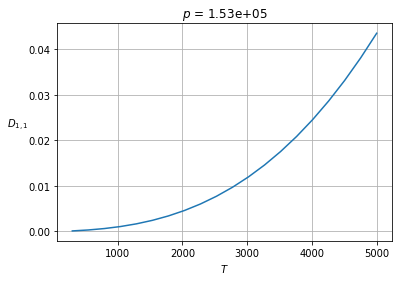

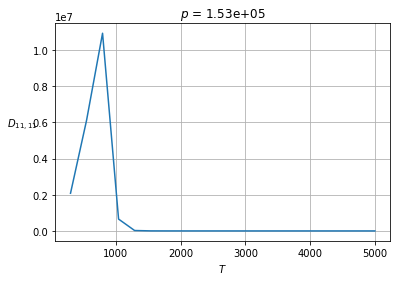

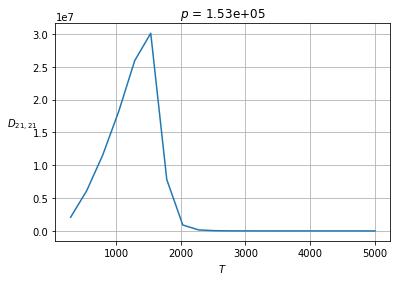

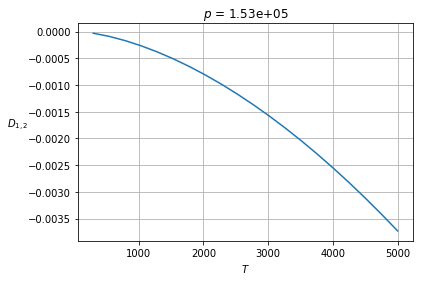

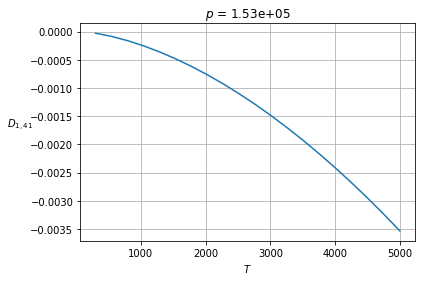

In [9]:
# Фиксируем точку по концентрациям (количественным долям)
# и по p
p_value = p_mesh[p_points//2]
inds = np.all(mesh[:, 2:] == x_mesh[3], axis = 1) * (mesh[:, 0] == p_value)
print('Fractions = ', x_mesh[3])
print('p = {0:5.2e}'.format(p_value))
print('inds size = ', np.sum(inds))

# Берём подмножество сетки
mesh_slice = mesh[inds, :]
# Подмножество данных 
data_slice2 = diff_coeffs[inds, :]

temp_values = mesh_slice[:, 1]

index_list = [[0, 0], 
              [10, 10], 
              [20, 20],
             [0, 1], 
             [0, 40]]
for i, j in index_list:
        # Одномерный индекс для матрицы, "выпрямленной" по стобцам
    index = j * N + i
    d_ij = data_slice2[:, index] # d
    plt.plot(temp_values, d_ij)
    plt.xlabel('$T$')
    plt.ylabel('$D_{' + str(i+1) +',' +  str(j+1) + '}$', rotation = 0, labelpad = 10)
    plt.grid(True)
    plt.title('$p$ = {0:5.2e}'.format(p_value))
    plt.show()

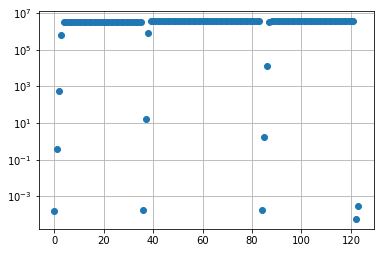

0.0
[[ 1.7048e-04 -4.3988e-05 -4.3988e-05 ... -4.3414e-05 -3.9696e-05
  -3.1345e-05]
 [-4.3988e-05  3.7411e-01 -4.3988e-05 ... -4.3414e-05 -3.9696e-05
  -3.1345e-05]
 [-4.3988e-05 -4.3988e-05  5.8286e+02 ... -4.3414e-05 -3.9696e-05
  -3.1345e-05]
 ...
 [-4.3414e-05 -4.3414e-05 -4.3414e-05 ...  3.4904e+06 -3.9132e-05
  -3.0563e-05]
 [-3.9696e-05 -3.9696e-05 -3.9696e-05 ... -3.9132e-05  5.9565e-05
  -2.3191e-05]
 [-3.1345e-05 -3.1345e-05 -3.1345e-05 ... -3.0563e-05 -2.3191e-05
   3.0017e-04]]


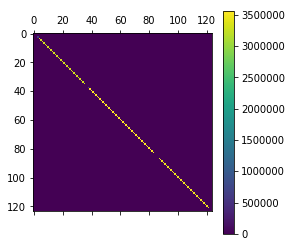

In [19]:
# print(diff_coeffs[0, :100])


diff_mat = np.reshape(diff_coeffs[0, :], (124, 124), order = 'F')
diag = np.diag(diff_mat)
# plt.semilogy(diff_mat[:,0])
# plt.semilogy(diff_mat[:,1])
# plt.semilogy(diff_mat[:,2])
# plt.semilogy(diff_mat[:,3])
plt.semilogy(diag[:], 'o')
plt.grid(True)
plt.savefig('Diagonal_vs_index.png', dpi = 600)
plt.show()

plt.matshow(diff_mat[:, :])
print(np.linalg.norm(diff_mat - diff_mat.T))
print(diff_mat[:, :])
plt.colorbar()
plt.savefig('diff_matrix.png', format = 'png', dpi = 600)